In [ ]:
%%capture
!pip install datasets transformers

In [ ]:
from transformers import BertTokenizer

# Machine Learning for NLP

# Building blocks

In this part, we will discover how to build a first neural network for text classification, step by step.

🚧 **TODO** 🚧

Propose a chain of operations that should be applied to the input text, from the input to the output.
When it applies, write the dimension of the expected tensors.

**Answer**

- Tokenizer le texte
- Mapper les IDs aux embeddings
- Aggréger les embeddings en un seul vecteur de taille `d` par document
- Classifier multi-classes à partir de ce vecteur de document

## Tokenizer

During the last course and during the HW, you used a `WhiteSpaceTokenizer` to tokenize the text.

Here, we are going to use the tokenizer from the model `Bert`, that we will describe later in the course. It comes with the `transformers` library.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sent = "I love footballing"
ids = tokenizer.encode(sent)
for i in ids:
    print(i, tokenizer.ids_to_tokens[i])


101 [CLS]
1045 i
2293 love
2374 football
2075 ##ing
102 [SEP]


**Dataset**

We will use the AGNews dataset. It is a dataset with 4 classes: World, Sports, Business, Sci/Tech. We download it from HuggingFace Hub [here](https://huggingface.co/datasets/fancyzhx/ag_news).

In [ ]:
from datasets import load_dataset
import unicodedata
import re

dataset = load_dataset("fancyzhx/ag_news")
dataset = dataset["train"]
dataset = dataset.shuffle(seed=42)
dataset = dataset.select(range(3000))
dataset = dataset.train_test_split(test_size=0.3)

print(dataset)


def preprocess_text(text: str) -> str:
    # TODO lower case
    text = text.lower()

    # TODO string normalization.
    text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode()

    # TODO remove non alpha numeric characters.
    text = re.sub(r"[^a-z0-9]", " ", text)

    # TODO replace numbers by the <NUM> token.
    text = re.sub(r"\d+", "<NUM>", text)

    # TODO remove double whitespaces.
    text = re.sub(" +", " ", text.strip())
    return text


# Clean the dataset
dataset = dataset.map(lambda x: {"text": preprocess_text(x["text"])})

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2100
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 900
    })
})


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

## Word vectors

The first step since we have access to text in a tokenized form is to use word embeddings.

### Embeddings


🚧 **TODO** 🚧

Experiment with the class `nn.Embedding` from PyTorch.

Construct an embedding layer with:
- `d_embed=50` dimensions
- `n_vocab=V` words in the vocabulary

Then try to get the embedding of the following sentence: `"I love machine learning."`.

In [ ]:
from torch import nn
import torch
d_embed = 5
n_vocab = len(tokenizer)

embedding_model = nn.Embedding(
    num_embeddings=n_vocab, embedding_dim=d_embed
)

sentence = "I love machine learning"
tokens = tokenizer(sentence, return_tensors="pt")["input_ids"]
print('Token ids:', tokens)
vectors = embedding_model(tokens)
print('Embedding:')
print(vectors)

Token ids: tensor([[ 101, 1045, 2293, 3698, 4083,  102]])
Embedding:
tensor([[[ 0.7403,  2.4777,  0.7951, -0.7436, -1.8402],
         [ 2.0075,  1.2725, -1.2053, -2.4803,  0.1187],
         [-1.0169,  0.4793,  0.4454, -0.4643,  0.8442],
         [ 0.5979, -0.2051, -0.6606, -1.6262, -2.0163],
         [ 0.4232,  0.4806, -0.5440,  0.2497, -1.0013],
         [-0.0846, -0.7424, -0.0695, -1.7643,  0.5274]]],
       grad_fn=<EmbeddingBackward0>)


In [ ]:
embedding_model.weight.shape

torch.Size([30522, 5])

In [ ]:
sentence = "I love Paris"
tokens = tokenizer(sentence, return_tensors="pt")["input_ids"]
print('Token ids:', tokens)
vectors = embedding_model(tokens)
print('Embedding:')
print(vectors.shape)

Token ids: tensor([[ 101, 1045, 2293, 3000,  102]])
Embedding:
torch.Size([1, 5, 5])


### Aggregation function

Since we need to perform document classfications, we need to aggregate the embeddings into a single vector of size `d`.

### Classification

The last layer of the network should be a linear layer with `c` classes.

🚧 **TODO** 🚧

Write a class named "WordEmbedClassifier" that will take as input a list of ids and return the probability of each class.

In [ ]:
class WordEmbedClassifier(nn.Module):
    def __init__(self, vocab_size, d, n_classes=4):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d)

        self.class_projection = nn.Linear(d, n_classes)

    def forward(self, x):
        # x (B, L)
        x_embeds = self.embedding_layer(x) # (B, L, d)

        x_vector = x_embeds.mean(axis=1) # (B, d)

        class_scores = self.class_projection(x_vector) # (B, n_classes)

        # class_proba = torch.nn.functionnal.softmax(class_logits)
        return class_scores

In [ ]:
# Try the model on a simple input:
length = 10
model = WordEmbedClassifier(d=5, n_classes=4, vocab_size=len(tokenizer))
x = tokenizer(["I live Paris", "I live Paris"], return_tensors="pt")["input_ids"]
print(x.shape)
output = model(x)
print(output.shape)
print(output)

torch.Size([2, 5])
torch.Size([2, 4])
tensor([[ 0.2142,  0.0573, -0.1861,  0.1308],
        [ 0.2142,  0.0573, -0.1861,  0.1308]], grad_fn=<AddmmBackward0>)


## Training

For training we need to iterate over the dataset.

### Data preparation

Here, we will assume that all texts have the same length, using truncation and discarding examples.

🚧 **Question** 🚧

Why do we need to have inputs of the same length?

**Answer**

Because we put them into tensors.

In [ ]:
def tokenize_truncate_and_discard(texts_list, labels_list, tokenizer, length=50):
    new_texts = []
    new_labels = []
    for text, label in zip(texts_list, labels_list):
        tokenized_text = tokenizer.encode(text)
        if len(tokenized_text) < length:
            continue
        new_texts.append(tokenized_text[:length])
        new_labels.append(label)

    return new_texts, new_labels


train_texts, train_labels = tokenize_truncate_and_discard(
    dataset["train"]["text"], dataset["train"]["label"], tokenizer
)
test_texts, test_labels = tokenize_truncate_and_discard(
    dataset["test"]["text"], dataset["test"]["label"], tokenizer
)

train_dataset = [(t, l) for t, l in zip(train_texts, train_labels)]
valid_dataset = [(t, l) for t, l in zip(test_texts, test_labels)]

print("Size before truncating:", len(dataset["train"]["text"]))
print("Size after truncating:", len(train_texts))

Size before truncating: 2100
Size after truncating: 953


Now we need to make batches of examples. We will use the DataLoader class from PyTorch.

🚧 **TODO** 🚧

Load the data into batches. One batch should be a dictionary with the following keys:
- `"input_ids"`: tensor of size (batch_size, L)
- `"labels"`: tensor of size (batch_size,)

In [ ]:
from torch.utils.data import DataLoader


class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of tuples (text, label)
        texts, labels = zip(*batch)
        # Encode the texts
        return {"input_ids": torch.tensor(texts), "labels": torch.tensor(labels)}


data_collator = DataCollator(tokenizer)

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
n_valid = len(valid_dataset)
n_train = len(train_dataset)

🔴 **TEST**

In [ ]:
batch = next(iter(train_dataloader))
print(batch)
assert isinstance(batch, dict)
assert "input_ids" in batch
assert "labels" in batch
assert isinstance(batch["input_ids"], torch.Tensor)
assert isinstance(batch["labels"], torch.Tensor)
assert batch["input_ids"].shape[0] == batch_size
assert batch["labels"].shape[0] == batch_size

{'input_ids': tensor([[  101, 11867,  2595,  ...,  1037, 14181,  2604],
        [  101, 27776,  9289,  ...,  2056,  6928,   102],
        [  101,  1052,  8873,  ...,  2019,  2972,  2465],
        ...,
        [  101,  7588,  1055,  ...,  2004,  2002,  2018],
        [  101,  2004, 19968,  ...,  2004, 19968,   102],
        [  101, 19340,  4115,  ...,  3969, 14711,  1999]]), 'labels': tensor([2, 2, 2, 3, 2, 3, 1, 2, 2, 2, 1, 1, 1, 0, 2, 1, 2, 3, 1, 2, 0, 1, 1, 2,
        3, 2, 3, 1, 0, 3, 3, 1])}


### Training loop

🚧 **TODO** 🚧

Now write the training loop. Validate the model on the validation set every epoch. Don't forget to plot the learning curves.

Epoch 1: train_loss: 1.3215, train_accuracy: 0.4092, valid_loss: 1.2213, valid_accuracy: 0.5116
Epoch 2: train_loss: 0.9988, train_accuracy: 0.7429, valid_loss: 0.9393, valid_accuracy: 0.7147
Epoch 3: train_loss: 0.5446, train_accuracy: 0.9045, valid_loss: 0.6711, valid_accuracy: 0.7866
Epoch 4: train_loss: 0.2509, train_accuracy: 0.9675, valid_loss: 0.5682, valid_accuracy: 0.7943
Epoch 5: train_loss: 0.1179, train_accuracy: 0.9937, valid_loss: 0.5878, valid_accuracy: 0.8098
Epoch 6: train_loss: 0.0615, train_accuracy: 0.9969, valid_loss: 0.5084, valid_accuracy: 0.8175
Epoch 7: train_loss: 0.0366, train_accuracy: 1.0000, valid_loss: 0.4919, valid_accuracy: 0.8252
Epoch 8: train_loss: 0.0250, train_accuracy: 1.0000, valid_loss: 0.5070, valid_accuracy: 0.8303
Epoch 9: train_loss: 0.0180, train_accuracy: 1.0000, valid_loss: 0.5120, valid_accuracy: 0.8252
Epoch 10: train_loss: 0.0138, train_accuracy: 1.0000, valid_loss: 0.4900, valid_accuracy: 0.8329


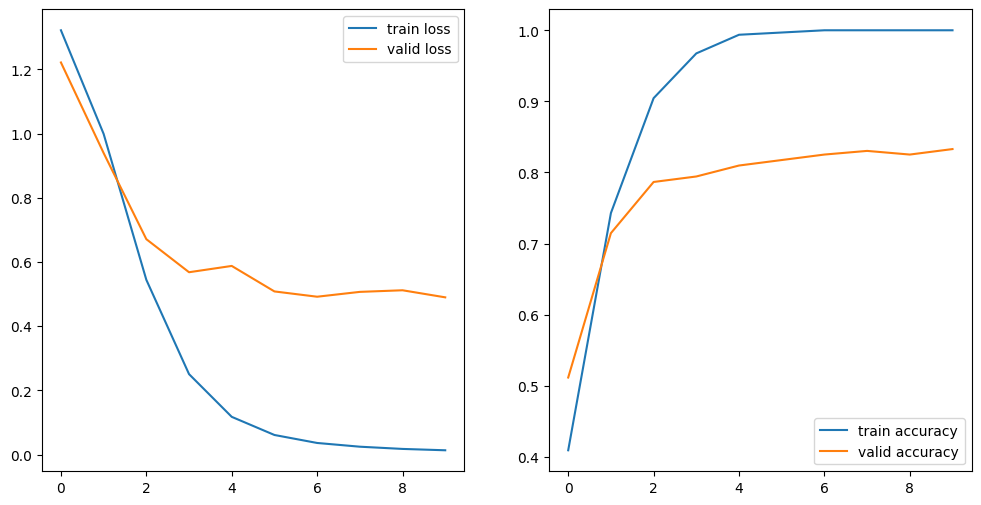

In [ ]:
import matplotlib.pyplot as plt
from torch import optim


# TODO
def validation_step(valid_dataloader, model, criterion):
    n_valid = len(valid_dataloader.dataset)
    model.eval()
    total_loss = 0.0
    correct = 0
    n_iter = 0
    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids = batch["input_ids"]
            labels = batch["labels"]
            output = model(input_ids)
            loss = criterion(output, labels)
            total_loss += loss.item()
            correct += (output.argmax(axis=-1) == batch["labels"]).sum().item()
            n_iter += 1
    return total_loss / n_iter, correct / n_valid


def train_one_epoch(train_dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    n_train = len(train_dataloader.dataset)
    n_iter = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        class_scores = model(batch["input_ids"]) # (B, 4)

        loss = criterion(class_scores, batch["labels"]) # scalaire (1,)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (class_scores.argmax(axis=-1) == batch["labels"]).sum().item()
        n_iter += 1

    return total_loss / n_iter, correct / n_train


def train(model, train_dataloader, valid_dataloader, lr=0.01, n_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    # Track training loss, training accuracy, validation loss and validation accuracy and plot in the end
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(
            train_dataloader, model, optimizer, criterion
        )
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(
            f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}"
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="valid loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="train accuracy")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()


model = WordEmbedClassifier(d=50, n_classes=4, vocab_size=len(tokenizer))

train(model, train_dataloader, valid_dataloader, n_epochs=10)

🚧 **TODO** 🚧

What do you think about the learning curves ?

## Padding and masking

Up to know, we assumed that our texts have the same length. To achieve that, we truncated the texts. However, in practive we want to keep the full texts (up to a given limit, of course)

We will investigate masking and padding to handle texts of different lengths.

🚧 **Question** 🚧

- What will padding achieve?
- What should we be careful about when using padding model?

**Answer**

TODO


In [ ]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # Tokenize the texts
        texts = [example["text"] for example in batch]
        labels = [example["label"] for example in batch]
        tokenized_texts = [self.tokenizer.encode(text) for text in texts]
        # Pad the tokenized texts
        max_len = max(len(text) for text in tokenized_texts)
        padded_texts = [
            text + [self.tokenizer.pad_token_id] * (max_len - len(text))
            for text in tokenized_texts
        ]
        pad_mask = [
            [1] * len(text) + [0] * (max_len - len(text)) for text in tokenized_texts
        ]
        return {
            "input_ids": torch.tensor(padded_texts),
            "pad_mask": torch.tensor(pad_mask),
            "labels": torch.tensor(labels),
        }


batch_size = 32
n_train = len(dataset["train"])
n_valid = len(dataset["test"])
data_collator = DataCollator(tokenizer)
train_dataloader = DataLoader(
    dataset["train"], batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    dataset["test"], batch_size=batch_size, collate_fn=data_collator, shuffle=True
)

In [ ]:
batch = next(iter(train_dataloader))
print(batch["input_ids"][:2, -50:])

tensor([[ 2008,  2045,  2097,  2022,  2053, 14770,  3913, 27475,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 2017,  3211,  6856,  2007,  8223,  9711, 18021,  2040,  2180,  2048,
          2088,  2186,  7635,  2007,  1996, 11081,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])


🚧 **TODO** 🚧

Update the code of the `WordEmbedClassifier` to handle padding.


In [ ]:
class WordEmbedClassifier(nn.Module):
    def __init__(self, vocab_size, d, n_classes=4):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, d)
        self.class_projection = nn.Linear(d, n_classes)

    def forward(self, input_ids, pad_mask):
        x_embed = self.embedding_layer(input_ids) # (B, L, d)

        # x_vector = x_embeds.mean(axis=1) # (B, d)
        n_non_pad = pad_mask.sum(axis=1, keepdim=True) # (B, 1), 1 because of keepdim=True

        # pad_mask (B, L), x_embed (B, L, d)
        x_embed = x_embed * pad_mask[:, :, None] # or pad_mask.unsqueeze(-1)
        x_vector  = x_embed.sum(axis=1) / n_non_pad

        class_scores = self.class_projection(x_vector) # (B, n_classes)

        return class_scores



🔴 **TEST**

In [ ]:
model = WordEmbedClassifier(d=50, n_classes=4, vocab_size=10000)

seq_len = 10
x_without_pad = torch.randint(0, 10000, (1, seq_len))
pad_mask = torch.ones(1, seq_len)
out_without_pad = model(x_without_pad, pad_mask)

x_with_pad = torch.randint(0, 10000, (1, 2 * seq_len))
pad_mask = torch.ones(1, 2 * seq_len)
pad_mask[:, seq_len:] = 0
out_with_pad = model(x_with_pad, pad_mask)

assert out_without_pad.shape == out_with_pad.shape

In [ ]:
# TODO
def validation_step(valid_dataloader, model, criterion):
    n_valid = len(valid_dataloader.dataset)
    model.eval()
    total_loss = 0.0
    correct = 0
    n_iter = 0
    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids = batch["input_ids"]
            labels = batch["labels"]
            pad_mask = batch["pad_mask"]
            output = model(input_ids, pad_mask)
            loss = criterion(output, labels)
            total_loss += loss.item()
            correct += (output.argmax(axis=-1) == batch["labels"]).sum().item()
            n_iter += 1
    return total_loss / n_iter, correct / n_valid


def train_one_epoch(train_dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    n_train = len(train_dataloader.dataset)
    n_iter = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        class_scores = model(batch["input_ids"], batch["pad_mask"]) # (B, 4)

        loss = criterion(class_scores, batch["labels"]) # scalaire (1,)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (class_scores.argmax(axis=-1) == batch["labels"]).sum().item()
        n_iter += 1

    return total_loss / n_iter, correct / n_train


def train(model, train_dataloader, valid_dataloader, lr=0.01, n_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track training loss, training accuracy, validation loss and validation accuracy and plot in the end
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(
            train_dataloader, model, optimizer, criterion
        )
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(
            f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}"
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="valid loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="train accuracy")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

Epoch 1: train_loss: 1.3461, train_accuracy: 0.3652, valid_loss: 1.2576, valid_accuracy: 0.4889
Epoch 2: train_loss: 1.0361, train_accuracy: 0.6662, valid_loss: 0.8813, valid_accuracy: 0.7056
Epoch 3: train_loss: 0.5768, train_accuracy: 0.8533, valid_loss: 0.6203, valid_accuracy: 0.7933
Epoch 4: train_loss: 0.3115, train_accuracy: 0.9348, valid_loss: 0.5327, valid_accuracy: 0.8200
Epoch 5: train_loss: 0.1801, train_accuracy: 0.9648, valid_loss: 0.5104, valid_accuracy: 0.8367
Epoch 6: train_loss: 0.1073, train_accuracy: 0.9848, valid_loss: 0.4876, valid_accuracy: 0.8389
Epoch 7: train_loss: 0.0665, train_accuracy: 0.9933, valid_loss: 0.5127, valid_accuracy: 0.8433
Epoch 8: train_loss: 0.0435, train_accuracy: 0.9976, valid_loss: 0.5010, valid_accuracy: 0.8400
Epoch 9: train_loss: 0.0302, train_accuracy: 0.9986, valid_loss: 0.5281, valid_accuracy: 0.8433
Epoch 10: train_loss: 0.0221, train_accuracy: 0.9995, valid_loss: 0.5130, valid_accuracy: 0.8389


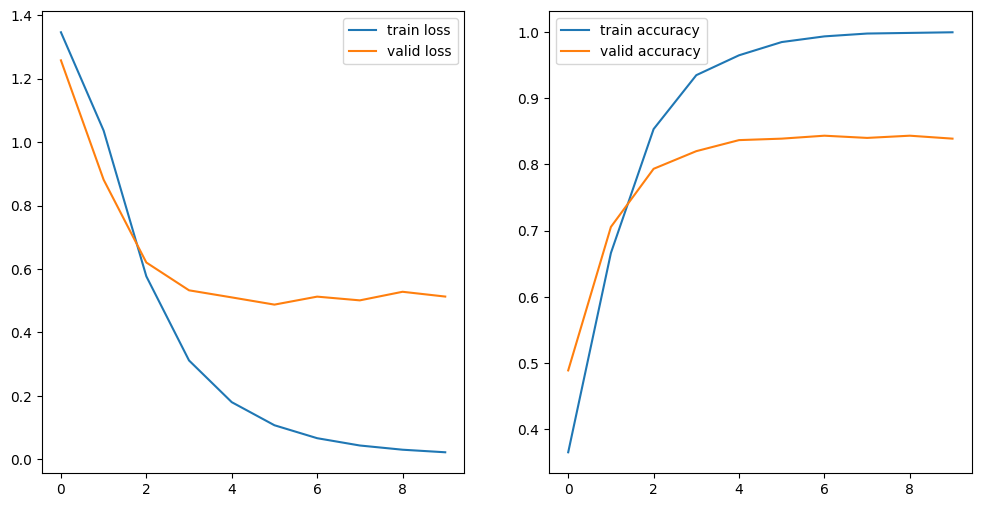

In [ ]:
model = WordEmbedClassifier(
    d=10,
    n_classes=4,
    vocab_size=len(tokenizer),
)
train(
    model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    lr=0.01,
    n_epochs=10,
)

## Sequence processing module

Now we built a simple classifier using word embeddings.

But is our model really different from a simple bag-of-words model?

🚧 **Question** 🚧

How can we make our model more powerful?

**Answer**

TODO

🚧 **Question** 🚧

What kind of module can we use?

**Answer**

TODO

## Convolution1D

Look at the documentation of the Conv1d layer. Read it carefully and try to completely understand the following code. A convolution layer expects a tensor as input, with the following dimensions *(B, D, L)*:
- B: size of the batch, the number of examples (here the number of sequences).
- D: the dimension of the vectors for each time step
- L: the length of the input sequence (the number of tokens in the sequence).

🚧 **Question** 🚧

Is this shape directly compatible with our Embeddings layer defined above?

🚧 **TODO** 🚧

- Make sure the following code computing a convolution run and is consistent.
- Draw what happens to better understand the obtained dimensions.

In [ ]:
d_embed = 50
embedding_layer = nn.Embedding(num_embeddings=len(tokenizer), embedding_dim=d_embed)

sequence_embedding = embedding_layer(batch["input_ids"][:2])
print("Sequence embedding shape:", sequence_embedding.shape)

convolution_layer = nn.Conv1d(in_channels=d_embed, out_channels=d_embed, kernel_size=3)
convolution_output = convolution_layer(sequence_embedding.transpose(1, 2)) # convolution input should be (B, D, L)
print("Convolution output shape:", convolution_output.shape)
output = convolution_output.transpose(1, 2)

Sequence embedding shape: torch.Size([2, 98, 50])
Convolution output shape: torch.Size([2, 50, 96])


🚧 **TODO** 🚧

Write a class named "Conv1dClassifier" that implements a convolutional neural network for text classification.

In [ ]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, d, n_classes=4):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, d)
        self.class_projection = nn.Linear(d, n_classes)
        self.conv1 = nn.Conv1d(d, d, kernel_size=3)
        self.conv2 = nn.Conv1d(d, d, kernel_size=3)

    def forward(self, input_ids, pad_mask):
        x_embed = self.embedding_layer(input_ids) # (B, L, d)
        x_embed = x_embed * pad_mask[:, :, None]
        x_embed = self.conv1(x_embed.transpose(1, 2))

        x_embed = torch.relu(x_embed)

        x_embed = self.conv2(x_embed).transpose(1, 2)

        # x_vector = x_embeds.mean(axis=1) # (B, d)
        pad_mask = pad_mask[:, 2:-2]
        n_non_pad = pad_mask.sum(axis=1, keepdim=True) # (B, 1), 1 because of keepdim=True
        # pad_mask (B, L), x_embed (B, L, d)
        x_embed = x_embed * pad_mask[:, :, None] # or pad_mask.unsqueeze(-1)
        x_vector  = x_embed.sum(axis=1) / n_non_pad

        class_scores = self.class_projection(x_vector) # (B, n_classes)
        return class_scores


Epoch 1: train_loss: 1.3888, train_accuracy: 0.2771, valid_loss: 1.3825, valid_accuracy: 0.3067
Epoch 2: train_loss: 1.3751, train_accuracy: 0.3210, valid_loss: 1.3716, valid_accuracy: 0.3167
Epoch 3: train_loss: 1.3564, train_accuracy: 0.3505, valid_loss: 1.3496, valid_accuracy: 0.3344
Epoch 4: train_loss: 1.3074, train_accuracy: 0.3819, valid_loss: 1.2987, valid_accuracy: 0.3522
Epoch 5: train_loss: 1.2246, train_accuracy: 0.4138, valid_loss: 1.2450, valid_accuracy: 0.3800
Epoch 6: train_loss: 1.1305, train_accuracy: 0.4676, valid_loss: 1.1899, valid_accuracy: 0.4278
Epoch 7: train_loss: 1.0340, train_accuracy: 0.5300, valid_loss: 1.1473, valid_accuracy: 0.4589
Epoch 8: train_loss: 0.9370, train_accuracy: 0.5781, valid_loss: 1.1127, valid_accuracy: 0.4933
Epoch 9: train_loss: 0.8506, train_accuracy: 0.6162, valid_loss: 1.0981, valid_accuracy: 0.5156
Epoch 10: train_loss: 0.7747, train_accuracy: 0.6533, valid_loss: 1.0767, valid_accuracy: 0.5333


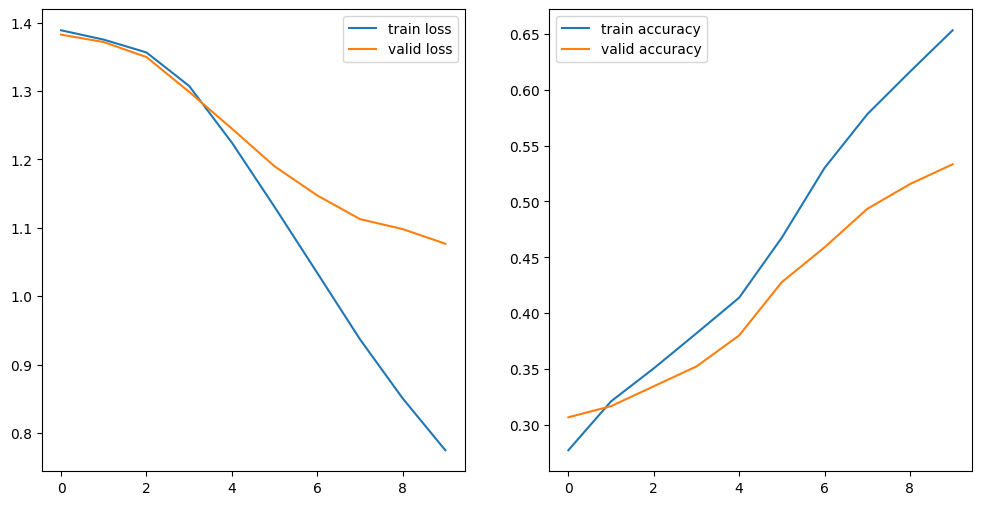

In [ ]:
model = ConvClassifier(
    d=10,
    n_classes=4,
    vocab_size=len(tokenizer),
)
train(
    model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    lr=0.001,
    n_epochs=10,
)